## ECE276C Assignment 2: Tabular Methods Report 

by Shivani Bhakta

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from numpy import genfromtxt
import random

### I. Question 1 - Model based Methods


### Part 1)
We are looking at a simple grid world problem called 'FrozenLake-v1'. We will describe this environment as follows:

* $\textbf{State Space: } \{0,1,3,..,16\}$ i.e the coordinates of the "bot" in the grid world of 4x4.

* $\textbf{Action space: } \{0,1,2,3\}$; where each of these controls map to following: \{ "Left": 0, "DOWN": 1, "RIGHT": 2, "UP": 3,  \}

* $\textbf{Reward function: }$

$$ 
r(s) = 
\begin{cases}
1  & \text{if s = $G$ (Goal)} \\
0  & \text{else (Frozen)} 
\end{cases}
$$


### Part 2)

A $\textbf{Markov Decision Process}$ is a stochastic process with costs/rewards and controlled transitions defined by a tuple  **(\mathcal{S}, \mathcal{A}, \mathcal{R}, \mathcal{P} ,\gamma )**. Each of these variables are defined as follows: 


$\Rightarrow$ $\mathcal{S} \in \mathbb{R}^{n} $ is a state space

$\Rightarrow$ $\mathcal{A} \in \mathbb{R}^{m} $ is the action space

$\Rightarrow$ $\mathcal{R} : \mathbb{R}^{m} \times \mathbb{R}^{n} \times \mathbb{R}^{m} \Rightarrow \mathbb{R} $ is the reward function

$\Rightarrow$ $\mathcal{P} : \mathbb{R}^{m} \times \mathbb{R}^{n} \times \mathbb{R}^{m}  \Rightarrow [0,1] $ is the transition probability. 

$\Rightarrow$ $\gamma$ is a discount factor $ \in [0,1] $ 



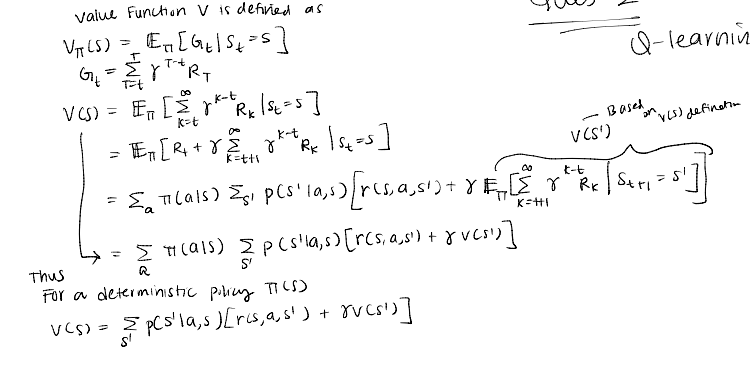



### Part 3)

The success rate of a policy given by π(s) = (s+1)%4, where % is the modulus operator is :  0.02

In [2]:
def TestPolicy(pi):
    """
    This function returns the average rate of successful episodes 
    over 100 trials for a deterministic policy.
    
    :param pi: a deterministic policy
    
    :return avg_return: success rate 
    """
#     env = gym.make('FrozenLake-v1')
    success_rate = 0
    env = gym.make('FrozenLake-v1')
    env.reset()
    trials=100
    
    for ii in range(trials):
        state = env.reset()
        done = False
        while not done:
            A = pi[state]
            s_prime, reward, done, info = env.step(A)
            state = s_prime
#             i,j = env.s // env.ncol, env.s % env.ncol  # get the coordinates to see if it's S,F,H, or G
#             count += 1
#             if env.desc[i,j] in b"GH":
#                 break
        if state == 15:
            success_rate += 1

    env.close()
    success_rate = success_rate/trials
    
    return success_rate

In [3]:
######################################################################
############################ Problem 1.3 ############################
######################################################################
env = gym.make('FrozenLake-v1', is_slippery=True)
Policy_test = lambda s: (s+1)%4
success_rate = TestPolicy(Policy_test(np.arange(16)))
print("The success rate of a policy given by π(s) = (s+1)%4, where % is the modulus operator is : ", success_rate )

The success rate of a policy given by π(s) = (s+1)%4, where % is the modulus operator is :  0.0


### Part 4

In [4]:
def LearnModel(env):
    """
    This function estimates the transition probabilities and reward function over 1e5 random samples. 
    
    :param env: gym environment object
    
    :returns: P: transition Probability p(s′|a,s)
              R: Reward function r(s, a, s′)
    
    """
    
    # get the dimensions of state and action space 
    num_action =  env.action_space.n 
    num_states =  env.observation_space.n
    
    # initialize the P, R 
    P = np.zeros((num_states,num_action,num_states)) # transition probability: SxAxS' -> [0,1]
    R = np.zeros((num_states,num_action,num_states))    # Reward function: SxA
    Q = np.zeros((num_states,num_action,num_states))
    counter = 0 

    while counter < 100000:
        done = False
        state = env.reset()
        while not done: 
            
            # get random action 
            action = env.action_space.sample() 
            s_prime, reward, done, info = env.step(action)
            
            #update the probability and reward function 
            P[state, action, s_prime] += 1
            R[state, action, s_prime] += reward
            Q[state, action, s_prime] += 1
            counter += 1 
            state = s_prime
    
    Q[Q == 0] = 1
    for ii in range(num_states): 
        for jj in range(num_action): 
            get_norm = np.linalg.norm(P[ii,jj,:], ord = 1)
            if get_norm != 0: 
                P[ii,jj,:] = P[ii,jj,:]/get_norm
    
    R /= Q
    return P,R

In [5]:
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()
P,R = LearnModel(env)

### Part 5

In [6]:
def PolicyEval(env,P,R,pi,V, gamma = 1.0):
    
    """
    :param env : gym environment object 
    :param P   : transition matrix 
    :param R.  : reward     
    
    """
    
    # get the dimensions of state and action space 
    num_action =  env.action_space.n 
    num_states =  env.observation_space.n
    
    
    for state in range(num_states):
        
        v = V[state]
        action = pi[state]
        sum_temp = 0
        
        for s_prime in range(num_states):
            sum_temp += P[state,action,s_prime] * \
                    (R[state,action,s_prime] + gamma * V[s_prime])
            
        V[state] = sum_temp

    return V, pi


def PolicyIter(env,P,R,gamma = 1.0, num_iter = 50):
    
    # get the dimensions of state and action space 
    num_action =  env.action_space.n 
    num_states =  env.observation_space.n
    success_rate = []
    
    # initialization
    pi = np.zeros(num_states,dtype='int')
    V = np.zeros(num_states)
    
    for i in range(num_iter):     
        #Policy Eval
        V,pi = PolicyEval(env,P,R,pi,V,gamma)
        
        # Policy improvement
        for j in range(100): 
            pi_temp = pi.copy()
            for state in range(num_states):
                Q = np.zeros(num_action)
                for action in range(num_action):
                    sum_temp = 0
                    for s_prime in range(num_states):
                        sum_temp += P[state,action,s_prime] * \
                                (R[state,action,s_prime] + gamma * V[s_prime])
                    Q[action] = sum_temp
                pi[state] = np.argmax(Q)
            
            if (pi == pi_temp).all(): 
                break 
        
#         policy = lambda s: pi[s]
        success_rate.append(TestPolicy(pi))

    return V, pi, success_rate

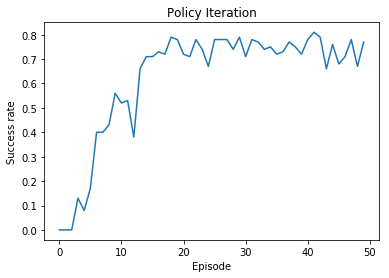

In [7]:
######################################################################
############################ Problem 1.5 ############################
######################################################################
# PolicyIter(P,R,env,gamma = 1.0, num_iter = 50):

gamma = 0.99

V, pi, success_rate = PolicyIter(env,P,R,gamma,50)

plt.figure()
plt.plot(success_rate)
plt.title("Policy Iteration")
plt.xlabel('Episode')
plt.ylabel('Success rate')
plt.savefig('Question 1_4.png')

In [8]:
# Using the Pi we will solve the environment 
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()

env.render()
# print(dir(env))

state = env.s
for i in range(1000):
    action = pi[state]
    next_state, reward, done, info = env.step(action)
    state = next_state
    env.render()
    if done: 
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


In [9]:
def ValueIter(env,P,R,gamma = 1.0, num_iter = 50):
    
    # get the dimensions of state and action space 
    num_action =  env.action_space.n 
    num_states =  env.observation_space.n
    
    # initialize the Pi, Q 
    pi = np.zeros(num_states,dtype='int') # policy is an int --> [0,1,2,3]
    V = np.zeros(num_states)
    
    success_rate = []
    
    for i in range(num_iter):
        
        for state in range(num_states):
#             v = V[state]
            Q = []
            for action in range(num_action):
                # Q = np.zeros((num_action,num_states))
                sum_temp = 0
                for s_prime in range(num_states):
                    sum_temp += P[state,action,s_prime] * (R[state,action,s_prime] + gamma*V[s_prime])
                Q.append(sum_temp)
            
            V[state] = max(Q) 
            
        for state in range(num_states):
            Q = []
            for action in range(num_action):
                sum_temp = 0
                for s_prime in range(num_states): 
                    sum_temp += P[state,action,s_prime] * (R[state,action,s_prime] + gamma*V[s_prime])
                Q.append(sum_temp)
            pi[state] = np.argmax(Q)
            
#         policy = lambda s: pi[s]
        success_rate.append(TestPolicy(pi))
    

    return pi, success_rate

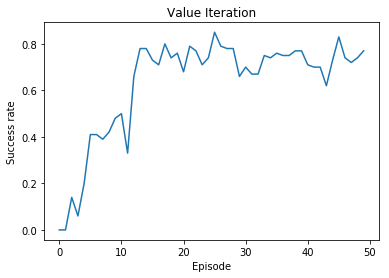

In [10]:
######################################################################
############################ Problem 1.6 ############################
######################################################################
gamma = 0.99

pi, success_rate = ValueIter(env,P,R,gamma, 50)

plt.figure()
plt.plot(success_rate)
plt.title("Value Iteration")
plt.xlabel('Episode')
plt.ylabel('Success rate')
plt.savefig('Question 1_5.png')

In [11]:
# Using the Pi we will solve the environment 
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()

env.render()
# print(dir(env))

state = env.s
for i in range(1000):
    action = pi[state]
    next_state, reward, done, info = env.step(action)
    state = next_state
    env.render()
    if done: 
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


### Question 2: Model Free Methods

In [12]:
# Question 2
def QLearning(env,alpha,gamma):
    
    # get the dimensions of state and action space 
    num_action = int(env.action_space.n) 
    num_states = int(env.observation_space.n)
    
    # initialize 
    Q = np.zeros((num_states,num_action))
    success_rate = []
    for episode in range(5000):
        s = env.reset()
        done = False
        while not done:
#             explore_strategy = 'e_greedy'
#             explore_strategy = 'softmax'
            
            # Get Action based on what kind of algorithm we have
#             if explore_strategy == 'softmax':
#                 diff = Q[s] - np.max(Q[s])
#                 e = np.exp(diff/500)
#                 p_action =  e / np.sum(e)
#                 get_sum = np.cumsum(p_action)
#                 a = np.where(np.random.rand() < get_sum)[0][0]
#             elif explore_strategy == 'e_greedy':
            if np.all(Q[0] == Q) or random.random() < (1 - episode / 5000):
                a = random.choice([0, 1, 2, 3]) #np.random.randint(0,4)
            else:
                a = np.argmax(Q[s]) # greedy

            
            s_prime, reward, done, info = env.step(a)
            Q[s,a] += alpha * (reward + gamma*np.max(Q[s_prime]) - Q[s,a])
            s = s_prime
        
        if episode%100 == 0 and episode >= 100: #divisible by 100.
            pi = [np.argmax(Q[i]) for i in range(num_states)]
            
#             policy = lambda s: pi[s]
            
            success_rate.append(TestPolicy(pi))
    return Q,pi,success_rate

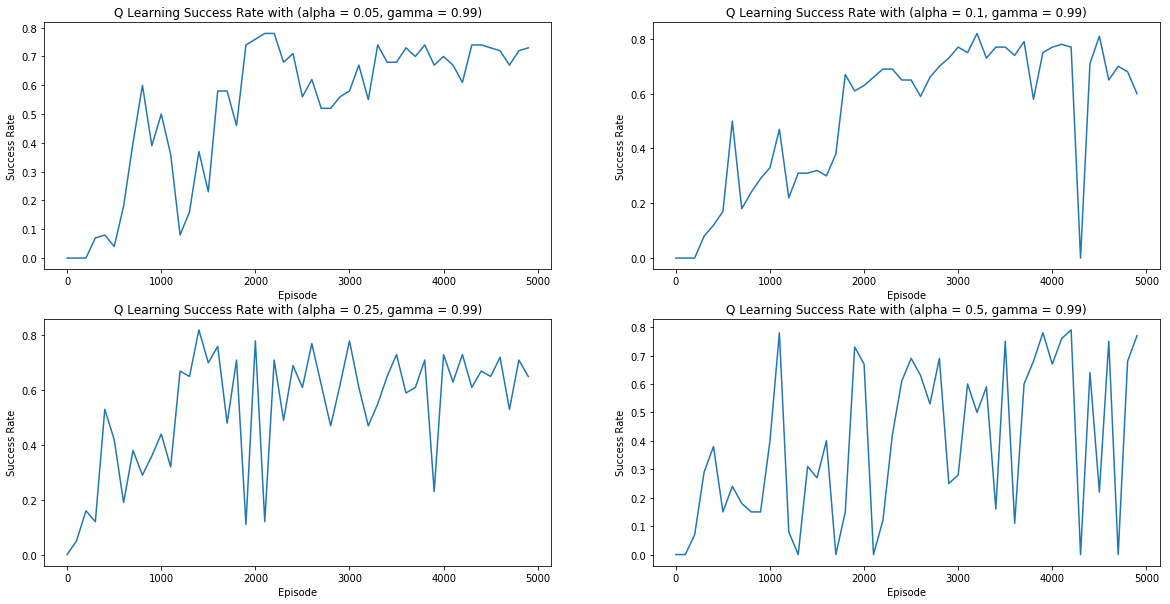

In [13]:
######################################################################
############################ Problem 2-1 ############################
######################################################################
env = gym.make('FrozenLake-v1')
env.reset()

alpha_list = [0.05, 0.1, 0.25, 0.5]
gamma = 0.99
plt.figure(figsize=(20, 10))

for i, alpha in enumerate(alpha_list):
    
    Q,pi,success_rate = QLearning(env,alpha,gamma)
    
    plt.subplot(2,2,i+1)
    plt.plot(range(0, 5000, 100),[0]+success_rate)
    plt.title('Q Learning Success Rate with (alpha = {}, gamma = {})'.format(alpha,gamma))
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
plt.savefig('Question 21a.png')

In [14]:
# Using the Pi we will solve the environment 
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()

env.render()
# print(dir(env))

state = env.s
for i in range(1000):
    action = pi[state]
    next_state, reward, done, info = env.step(action)
    state = next_state
    env.render()
    if done: 
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


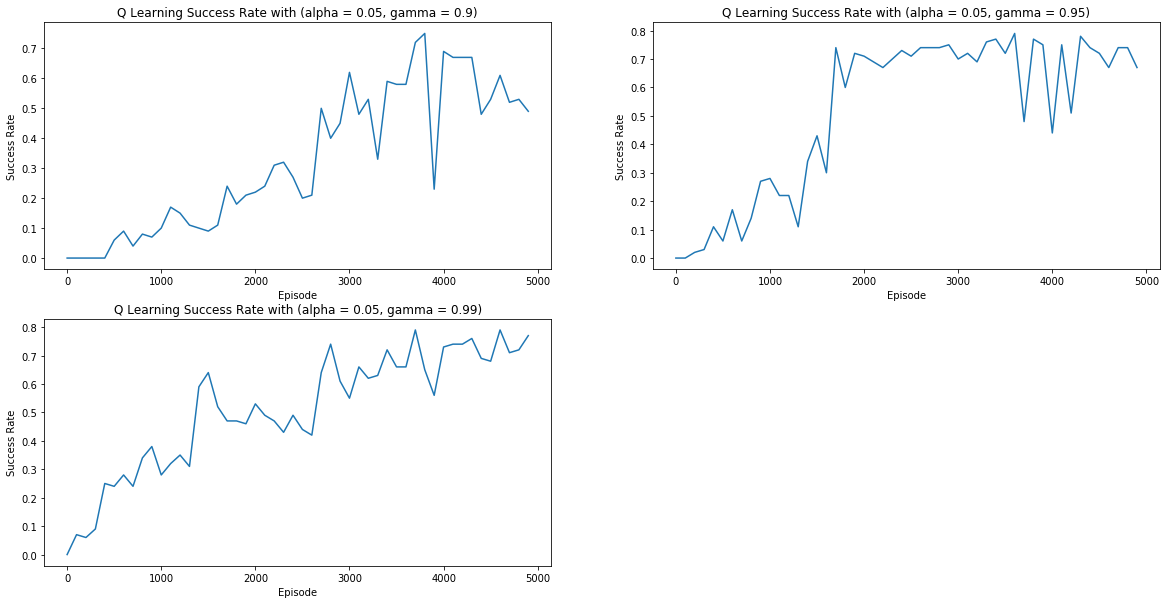

In [15]:
######################################################################
############################ Problem 2-1(b) ############################
######################################################################
env = gym.make('FrozenLake-v1')
env.reset()

gamma_list = [0.9, 0.95, 0.99]
alpha = 0.05
plt.figure(figsize=(20, 10))

for i, gamma in enumerate(gamma_list):
    
    Q,pi,success_rate = QLearning(env,alpha,gamma)
    
    plt.subplot(2,2,i+1)
    plt.plot(range(0, 5000, 100),[0]+success_rate)
    plt.title('Q Learning Success Rate with (alpha = {}, gamma = {})'.format(alpha,gamma))
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
plt.savefig('Question 2(1)b.png')

In [16]:
# Using the Pi we will solve the environment 
env = gym.make('FrozenLake-v1', is_slippery=True)
env.reset()

env.render()
# print(dir(env))

state = env.s
for i in range(1000):
    action = pi[state]
    next_state, reward, done, info = env.step(action)
    state = next_state
    env.render()
    if done: 
        break


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
